In [23]:
import matplotlib
import numpy as np
from numpy.random import SeedSequence
import psutil
import ray
import seaborn as sns
import time
import torch

# Set a global torch seed for reproducibility of torch RNG operations.
# Note: numpy's Generator (default_rng) is used separately and seeded where needed.
torch.manual_seed(42)

import matplotlib.pyplot as plt
import numpy.linalg as la

sns.set(style="whitegrid", context="talk", font_scale=1.2, palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'DejaVu Sans'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (9, 6)

# Baseline

In [24]:
iterations = 800
num_workers = 32
it_check = 32 #
n_seeds = 5 #
max_seed = 424242 #
rng = np.random.default_rng(42)

seeds = rng.choice(max_seed, size=n_seeds, replace=False) # seeds 里的随机种子不相同

n_data = 10000
dim = 400
batch_size = 256
noise_scale = 1e-1


Text(0, 0.5, '$log(F(\\mathbf{x}) - F^*)$')

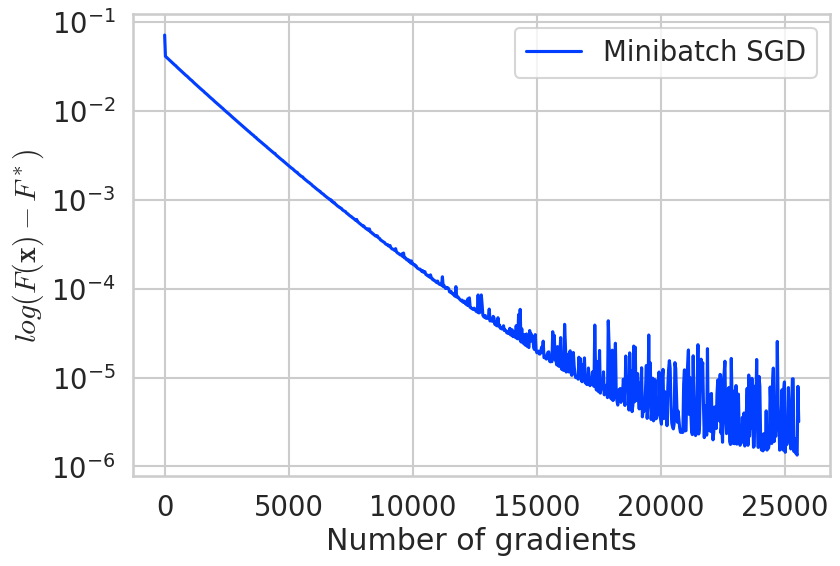

In [25]:

A = rng.uniform(size=(n_data, dim)) / np.sqrt(dim)
x_rand = rng.normal(size=dim)
b = A @ x_rand + noise_scale * rng.normal(size=n_data)# baseline


def batch_grad_func(rng, x, batch_size):
    idx = rng.choice(n_data, size=batch_size, replace=False)
    return (A[idx]@x - b[idx]) @ A[idx] / batch_size

def evaluate(x):
    assert len(x) == dim
    return 0.5 * np.mean((A @ x - b)**2)

def run_single_worker_sgd(lr, iterations, batch_size, it_check):
    """
    Runs a single-worker (pure) minibatch SGD.
    """
    rng = np.random.default_rng(42)
    x = np.zeros(dim)
    
    trace = []
    its = []
    ts = []
    t0 = time.perf_counter()
    
    for it in range(iterations):
        # Calculate gradient on a large batch
        grad = batch_grad_func(rng, x, batch_size)
        
        # Update model
        x -= lr * grad
        
        if it % it_check == 0:
            trace.append(x.copy())
            its.append(it)
            ts.append(time.perf_counter() - t0)
            
    return np.asarray(its), np.asarray(ts), np.asarray([evaluate(x) for x in trace])

x_opt, _, _, _ = np.linalg.lstsq(A, b)
f_min = evaluate(x_opt)

iterations_single = iterations * num_workers

its_single, ts_single, losses_single = run_single_worker_sgd(
    lr=1.3906,
    iterations=iterations_single,
    it_check=it_check,
    batch_size=batch_size
)
plt.plot(its_single, losses_single - f_min, label='Minibatch SGD')
plt.yscale('log')
plt.legend()
plt.xlabel('Number of gradients')
plt.ylabel(r'$log(F(\mathbf{x}) - F^*)$')




# Parameters

In [26]:
iterations = 800
num_workers = 32

n_seeds = 5 # 
max_seed = 424242 #
rng = np.random.default_rng(42)
seeds = rng.choice(max_seed, size=n_seeds, replace=False) # seeds 里的随机种子不相同的。
    
n_data = 10000
dim = 400
batch_size = 256
noise_scale = 1e-1
A = torch.from_numpy(rng.uniform(size=(n_data, dim)) / np.sqrt(dim)).float()
x_rand = torch.from_numpy(rng.normal(size=dim)).float()
b = A @ x_rand + noise_scale * torch.from_numpy(rng.normal(size=n_data)).float()
b = b.reshape(n_data, 1)

print(psutil.cpu_count(logical=True)) # Number of logical CPUs

152


# Objective function

In [27]:
def least_squares_objective(A_in, b_in, x):
    return 0.5 * torch.mean((A_in @ x - b_in)**2)

def evaluate(x):
    assert len(x) == dim
    return least_squares_objective(A, b, x)

# Distributed Framework

In [28]:
x_opt_np, _, _, _ = np.linalg.lstsq(A.numpy(), b.numpy())
x_opt = torch.from_numpy(x_opt_np).float()
f_min = evaluate(x_opt)
print(f"Optimal value: {f_min:.6e}")

Optimal value: 4.842284e-03


# Minibatch-SGD

## Torch version

In [29]:
def run_single_worker_sgd(objective_fn, A, b, lr, iterations, batch_size, seed=42):
    """
    Runs a single-worker (pure) minibatch SGD for comparison.
    This is a non-distributed, standard implementation using PyTorch.
    """
    rng = np.random.default_rng(seed)
    x = torch.zeros(dim, 1, requires_grad=True)
    
    trace = []
    its = []
    ts = []
    t0 = time.perf_counter()
    
    for it in range(iterations):
        # Ensure gradients are enabled and zeroed out for the current iteration
        x.requires_grad = True
        if x.grad is not None:
            x.grad.zero_()

        # Sample a minibatch
        idx = rng.choice(A.shape[0], size=batch_size, replace=False)
        
        # Calculate gradient on the minibatch
        loss = objective_fn(A[idx], b[idx], x)
        loss.backward()
        grad = x.grad
        
        # Update model without tracking this operation in the graph
        with torch.no_grad():
            x -= lr * grad
        
        if it % num_workers == 0: # Note: num_workers is a global variable here
            trace.append(x.clone().detach())
            its.append(it)
            ts.append(time.perf_counter() - t0)
            
    return np.asarray(its), np.asarray(ts), np.asarray([evaluate(x_i).item() for x_i in trace])

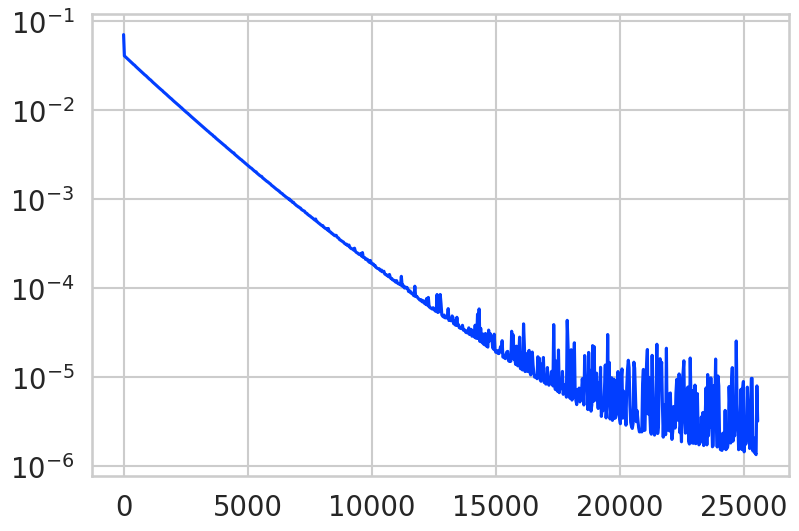

In [30]:
lr = 0.43
its_single, ts_single, losses_single = run_single_worker_sgd(
    objective_fn=least_squares_objective, 
    A=A, 
    b=b,
    lr=1.3906,
    iterations=iterations*num_workers,
    batch_size=batch_size
)

f_min_val = f_min.item()
plt.yscale('log')
plt.plot(its_single, losses_single - f_min_val, label='Single-worker SGD')


## cpu versipn

In [31]:
A_npy = rng.uniform(size=(n_data, dim)) / np.sqrt(dim)
x_rand_npy = rng.normal(size=dim)
b_npy = A_npy @ x_rand_npy + noise_scale * rng.normal(size=n_data)

def batch_grad_func(rng, x, batch_size):
    idx = rng.choice(n_data, size=batch_size, replace=False)
    return (A_npy[idx]@x - b_npy[idx]) @ A_npy[idx] / batch_size

def evaluate_npy(x):
    assert len(x) == dim
    return 0.5 * np.mean((A_npy @ x - b_npy)**2)

def run_single_worker_sgd(lr, iterations, batch_size):
    """
    Runs a single-worker (pure) minibatch SGD.
    """
    # rng = np.random.default_rng(42)
    x = np.zeros(dim)
    
    trace = []
    its = []
    ts = []
    t0 = time.perf_counter()
    
    for it in range(iterations):
        # Calculate gradient on a large batch
        grad = batch_grad_func(rng, x, batch_size)
        
        # Update model
        x -= lr * grad
        
        if it % it_check == 0:
            trace.append(x.copy())
            its.append(it)
            ts.append(time.perf_counter() - t0)
            
    return np.asarray(its), np.asarray(ts), np.asarray([evaluate_npy(x) for x in trace])

In [32]:
lr = 0.43
num_workers_single = 32
iterations_single = iterations * num_workers_single
its_single, ts_single, losses_single = run_single_worker_sgd(
    lr=1.3925,
    iterations=iterations_single,
    batch_size=batch_size
)

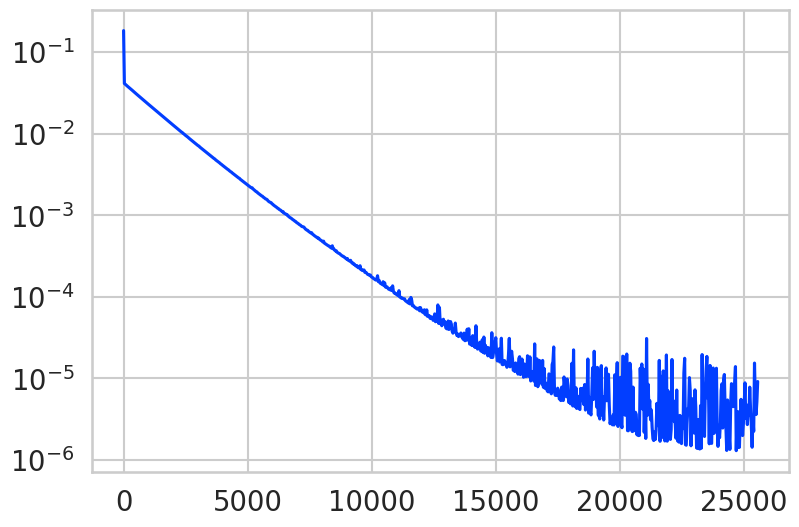

In [33]:
x_opt, _, _, _ = np.linalg.lstsq(A_npy, b_npy)
f_min = evaluate_npy(x_opt)
plt.yscale('log')
plt.plot(its_single, losses_single - f_min, label='Single-worker SGD')

# Distributed

## Distributed Framework

In [34]:
@ray.remote
class ParameterServer(object):
    """
    Parameter server for asynchronous and synchronous SGD.
    Arguments:
        lr (float): the stepsize to be used at initialization
        asynchronous (bool): if True, use asynchronous SGD; if False, use synchronous SGD
    """

    def __init__(self, lr, asynchronous):
        self.x = torch.zeros(dim, 1, requires_grad=True)
        self.lr = lr
        self.asynchronous = asynchronous

    def apply_gradients(self, grad, *gradients):
        # *可以把一串位置参数打包到一个元组里
        if self.asynchronous:
            self.x.data -= self.lr * grad
        else:
            summed_gradients = torch.sum(torch.stack(gradients), dim=0)
            self.x.data -= self.lr * summed_gradients
        return self.x

    def get_x(self):
        return self.x
    
    def update_lr(self, lr_coef_mul=1, lr_new=None):
        if lr_new is not None:
            self.lr = lr_new
        else:
            self.lr *= lr_coef_mul
        
    def get_hyperparams(self):
        return self.lr, self.asynchronous
    
    
@ray.remote
class DataWorker(object):
    """
    The class for an individual Ray worker.
    Arguments:
        objective_fn (callable): the objective function to compute loss
        A_shard (np.ndarray or torch.Tensor): a shard of the data matrix A
        b_shard (np.ndarray or torch.Tensor): a shard of the data vector b
        lr (float): the stepsize to be used at initialization
        batch_size (int, optional): batch size for sampling gradients (default: 1)
        seed (int, optional): random seed to generate random variables for reproducibility (default: 0)
    """
    def __init__(self, objective_fn, A_shard, b_shard, lr, batch_size=1, seed=0):
        # runtime checks
        if not callable(objective_fn):
            raise TypeError("objective_fn must be callable and accept (A_in, b_in, x) -> scalar torch.Tensor")

        self.A = A_shard
        self.b = b_shard
        self.n_data = A_shard.shape[0]
        self.lr = lr
        self.objective_fn = objective_fn
        self.batch_size = batch_size

        # Ensure seed is an int and create a local Generator so each worker is independent.
        self.seed = int(seed)
        self.rng = np.random.default_rng(self.seed)

    def compute_gradients(self, x):
        x.requires_grad = True
        if x.grad is not None:
            x.grad.zero_()
            
        t0 = time.perf_counter()
        if self.batch_size is None:
            # Full gradient
            loss = self.objective_fn(self.A, self.b, x)
            loss.backward()
            grad = x.grad
        elif self.batch_size == 1:
            # Stochastic gradient
            i = int(self.rng.integers(self.n_data))
            loss = self.objective_fn(self.A[i], self.b[i], x)
            loss.backward()
            grad = x.grad
        else:
            # M-sync gradient
            idx = self.rng.choice(self.n_data, size=self.batch_size, replace=False)
            loss = self.objective_fn(self.A[idx], self.b[idx], x)
            loss.backward()
            grad = x.grad
            
        return grad

        
    def get_hyperparams(self):
        return self.lr, self.batch_size
    
    def get_lr(self):
        return self.lr

## Distributed Algriothm

In [35]:
def run(num_workers, lr, iterations=200, asynchronous=True, delay_adaptive=False,
        batch_size=1, objective_fn=least_squares_objective, seed=42):
    """Run the distributed training.

    seed: int -- used to initialize the NumPy Generator that creates per-worker seeds.
    """
    worker_updates = [0 for i in range(num_workers)]
    rng = np.random.default_rng(seed)
    seeds_workers = rng.choice(max_seed, size=num_workers, replace=False)
    #seeds_workers = [rng.choice(max_seed, size=1, replace=False)[0] for _ in range(num_workers)]

    ray.init(ignore_reinit_error=True)
    
    # Partition the data and put it in the object store.
    A_shards = torch.chunk(A, num_workers)
    b_shards = torch.chunk(b, num_workers)
    A_shard_refs = [ray.put(shard) for shard in A_shards]
    b_shard_refs = [ray.put(shard) for shard in b_shards]

    ps = ParameterServer.remote(lr, asynchronous)
    # Ensure argument order matches DataWorker.__init__(objective_fn, A_shard, b_shard, lr, ...)
    workers = [DataWorker.remote(objective_fn,
                                 A_shard_refs[i], 
                                 b_shard_refs[i],
                                 lr=lr, 
                                 batch_size=batch_size, 
                                 seed=int(seeds_workers[i])) for i in range(num_workers)]

    x = ps.get_x.remote()
    if asynchronous:
        gradients = {}
        worker_last_it = [0 for _ in range(num_workers)]
        worker_id_to_num = {}
        for e, worker in enumerate(workers):
            gradients[worker.compute_gradients.remote(x)] = worker
            worker_id_to_num[worker] = e


    its = []
    ts = []
    delays = []
    t0 = time.perf_counter()
    delay = 0
    trace = []
    grads_per_it = 1 if asynchronous else num_workers

    for it in range(iterations * (num_workers if asynchronous else 1)):
        n_grads = it * grads_per_it # 异步时n_grads = it；同步时n_grads = it * num_workers
        if asynchronous:
            ready_gradient_list, _ = ray.wait(list(gradients),num_returns=1) #ray.wait作用在任务句柄的列表上，返回已经完成的任务句柄列表和未完成的任务句柄列表，只返回一个已经完成的任务句柄。
            ready_gradient_id = ready_gradient_list[0]
            worker = gradients.pop(ready_gradient_id) #从字典 gradients 中，删除并返回 key 为 ready_gradient_id 的那个 value（也就是对应的 worker 对象

            # Compute and apply gradients.
            gradients[worker.compute_gradients.remote(x)] = worker # 重新计算该 worker 的梯度，并将新的任务句柄存回 gradients 字典
            worker_num = worker_id_to_num[worker] # 获取该 worker 的编号
            delay = it - worker_last_it[worker_num] # 计算该 worker 的延迟
            if delay_adaptive:
                lr_new = lr * num_workers / max(num_workers, delay)
                # lr_new = lr * num_workers / max(num_workers, delay)
                ps.update_lr.remote(lr_new=lr_new)
            x = ps.apply_gradients.remote(grad=ready_gradient_id) # 针对已经计算完成的梯度进行参数更新
            worker_last_it[worker_num] = it
            worker_updates[worker_num] += 1
        else:
            gradients = [
                worker.compute_gradients.remote(x) for worker in workers
            ]
            # Calculate update after all gradients are available.
            x = ps.apply_gradients.remote(None, *gradients)

        if (asynchronous and it % num_workers == 0):
            # Evaluate the current model.
            x_val = ray.get(ps.get_x.remote())
            trace.append(x_val.clone().detach())
            its.append(it)
            ts.append(time.perf_counter() - t0)
        else:
            if not asynchronous:
                # Evaluate the current model.
                x_val = ray.get(ps.get_x.remote())
                trace.append(x_val.clone().detach())
                its.append(it*num_workers)
                ts.append(time.perf_counter() - t0)


        t = time.perf_counter()
        if asynchronous:
            delays.append(delay)

    ray.shutdown()
    return np.asarray(its), np.asarray(ts), np.asarray([evaluate(x) for x in trace]), np.asarray(delays)

## Synchronous Experiment

In [36]:
lr_mini = 0.43 # best tuned
lr_decay = 0
its_, ts_, losses_, delays = run(1, lr=lr_mini,
                                       iterations=iterations, asynchronous=False, delay_adaptive=False, batch_size=batch_size)

2025-11-19 03:37:30,772	INFO worker.py:2003 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
/home/cipher/miniconda3/envs/async/lib/python3.11/site-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


## Asynchronous Experiment

In [37]:
lr_as = 0.43 # best tuned
lr_decay = 0
its_as, ts_as, losses_as, delays = run(1, lr=lr_as,
                                       iterations=iterations, asynchronous=True, delay_adaptive=False, batch_size=batch_size)

2025-11-19 03:37:47,063	INFO worker.py:2003 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


In [38]:
lr_ad = 0.43 # best tuned
lr_decay = 0
its_ad, ts_ad, losses_ad, delays = run(1, lr=lr_ad,
                                       iterations=iterations, asynchronous=True, delay_adaptive=True, batch_size=batch_size)

2025-11-19 03:38:01,635	INFO worker.py:2003 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Text(0, 0.5, '$F(\\mathbf{x}) - F^*$')

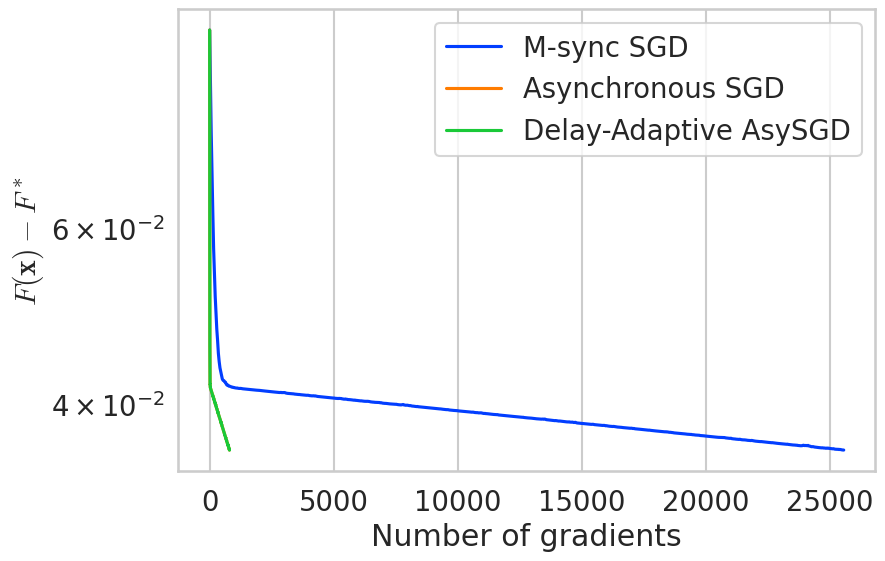

In [39]:

plt.plot(its_ * num_workers, losses_ - f_min_val, label='M-sync SGD')
plt.plot(its_as, losses_as - f_min_val, label='Asynchronous SGD')
plt.plot(its_ad, losses_ad - f_min_val, label='Delay-Adaptive AsySGD')
plt.yscale('log')
plt.legend()
plt.xlabel('Number of gradients')
plt.ylabel(r'$F(\mathbf{x}) - F^*$')
# plt.savefig(f'quadratic_grads_M_{num_workers}_n={n_data}_dim={dim}_bs_{batch_size}.pdf', bbox_inches='tight')

Text(0, 0.5, '$F(\\mathbf{x}) - F^*$')

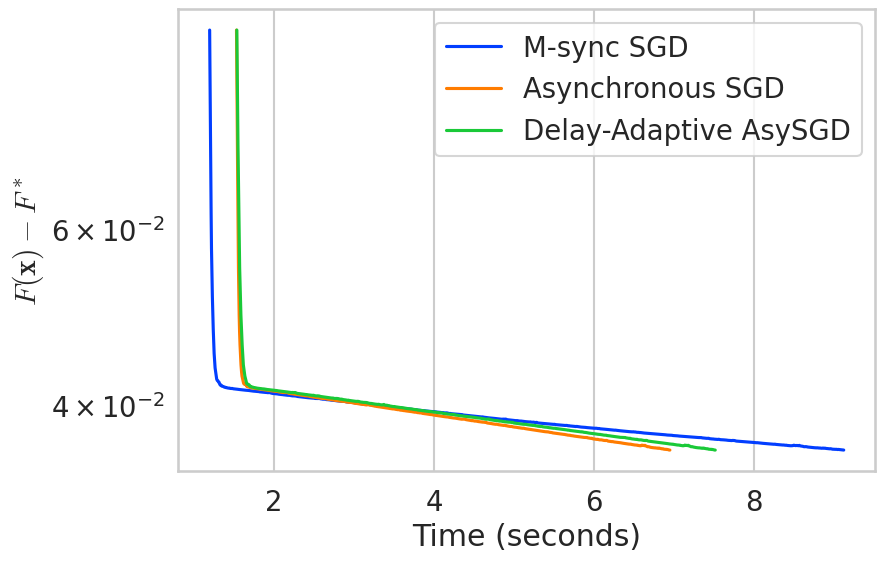

In [40]:
f_min_val = f_min.item()
plt.plot(ts_, losses_ - f_min_val, label='M-sync SGD')
plt.plot(ts_as, losses_as - f_min_val, label='Asynchronous SGD')
plt.plot(ts_ad, losses_ad - f_min_val, label='Delay-Adaptive AsySGD')

plt.yscale('log')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel(r'$F(\mathbf{x}) - F^*$')
# plt.savefig(f'quadratic_grads_M_{num_workers}_n={n_data}_dim={dim}_bs_{batch_size}.pdf', bbox_inches='tight')

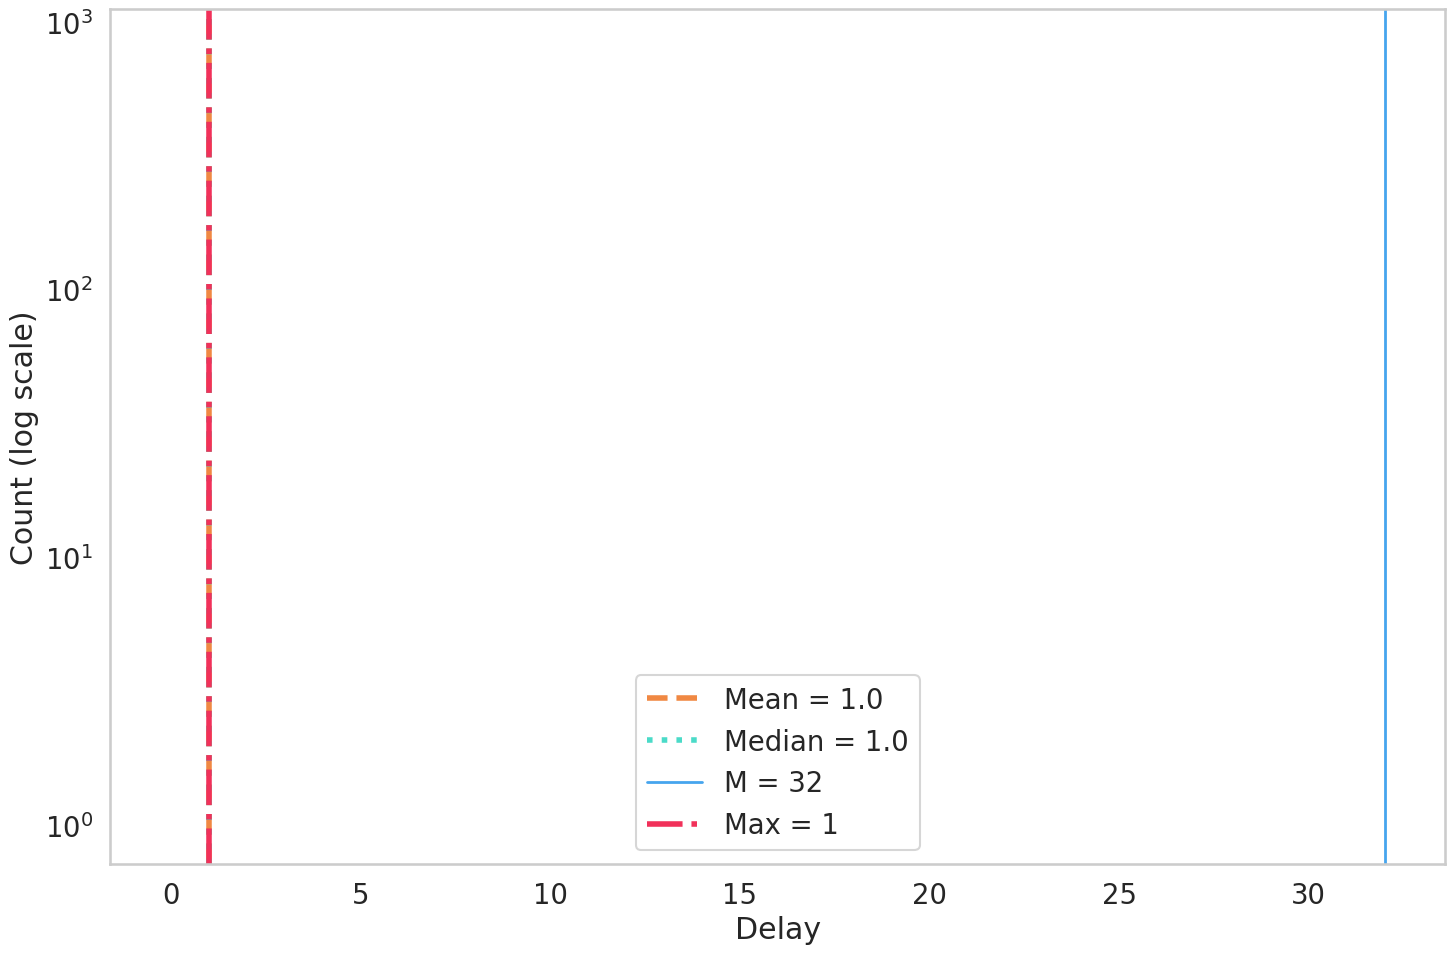

In [41]:
plt.figure(figsize=(15,10))

# 延迟直方图（对数 y 轴）
plt.hist(delays, bins=300, color="#CEC6C6", alpha=0.75)
plt.yscale('log')

# 统计量
mean_delay = np.mean(delays)
median_delay = np.median(delays)
max_delay = np.max(delays)

plt.axvline(mean_delay, color="#f08843", linestyle='--', linewidth=4, label=f'Mean = {mean_delay:.1f}')
plt.axvline(median_delay, color="#4bdbc8", linestyle=':', linewidth=4, label=f'Median = {median_delay:.1f}')
plt.axvline(num_workers, color="#46a5ee", linestyle='-', linewidth=2, label=f'M = {num_workers}')
plt.axvline(max_delay, color="#f1315a", linestyle='-.', linewidth=4, label=f'Max = {max_delay:.0f}')
plt.grid(False)
plt.xlabel('Delay')
plt.ylabel('Count (log scale)')
plt.legend()
plt.tight_layout()
# # plt.savefig(f'quadratic_delays_M_{num_workers}_n={n_data}_dim={dim}_bs={batch_size}.pdf', bbox_inches='tight')


# plt.hist(delays, bins=600)
# plt.axvline(num_workers, color='green', label=r'$M$', linewidth=6)
# plt.axvline(np.max(delays), color='red', label=r'$\tau_{\max}$')
# plt.xlabel('Delay')
# plt.ylabel('Frequency')
# plt.yscale('log')
# plt.legend()
# plt.savefig(f'quadratic_delays_M_{num_workers}_n={n_data}_dim={dim}_bs={batch_size}.pdf', bbox_inches='tight')

In [42]:

# batch_sizes_to_test = [8, 16, 32, 64, 128]
# results = {}

# # 为所有批处理大小使用相同的预设学习率，以便进行统一比较。
# # 同步算法的学习率设置为0.19，异步算法为0.43。
# lr_sync = 0.19
# lr_async = 0.43
# f_min_val = f_min.item()

# for bs in batch_sizes_to_test:
#     print(f"--- Running for batch_size = {bs} ---")
    
#     # (M-sync SGD)
#     print("Running Synchronous SGD...")
#     its_sync, ts_sync, losses_sync, _ = run(
#         num_workers, lr=lr_sync, iterations=iterations, 
#         asynchronous=False, delay_adaptive=False, batch_size=bs
#     )
    
#     # 异步算法
#     print("Running Asynchronous SGD...")
#     its_async, ts_async, losses_async, _ = run(
#         num_workers, lr=lr_async, iterations=iterations, 
#         asynchronous=True, delay_adaptive=False, batch_size=bs
#     )
    
#     # 自适应异步算法
#     print("Running Delay-Adaptive Asynchronous SGD...")
#     its_ad, ts_ad, losses_ad, delays_ad = run(
#         num_workers, lr=lr_async, iterations=iterations, 
#         asynchronous=True, delay_adaptive=True, batch_size=bs
#     )
    
#     results[bs] = {
#         'sync': {'ts': ts_sync, 'losses': losses_sync},
#         'async': {'ts': ts_async, 'losses': losses_async},
#         'adaptive': {'ts': ts_ad, 'losses': losses_ad},
#     }
#     print(f"--- Finished for batch_size = {bs} ---\n")

# # 对比图
# fig, axes = plt.subplots(1, 3, figsize=(27, 8), sharey=True)
# fig.suptitle('Comparison of Algorithms for Different Batch Sizes', fontsize=20)

# # (M-sync SGD)
# ax1 = axes[0]
# for bs in batch_sizes_to_test:
#     res = results[bs]['sync']
#     ax1.plot(res['ts'], res['losses'] - f_min_val, label=f'Batch Size = {bs}')
# ax1.set_title('Synchronous SGD')
# ax1.set_xlabel('Time (seconds)')
# ax1.set_ylabel(r'$F(\mathbf{x}) - F^*$')
# ax1.set_yscale('log')
# ax1.legend()
# ax1.grid(True)

# # (Asynchronous SGD)
# ax2 = axes[1]
# for bs in batch_sizes_to_test:
#     res = results[bs]['async']
#     ax2.plot(res['ts'], res['losses'] - f_min_val, label=f'Batch Size = {bs}')
# ax2.set_title('Asynchronous SGD')
# ax2.set_xlabel('Time (seconds)')
# ax2.set_yscale('log')
# ax2.legend()
# ax2.grid(True)

# # (Delay-Adaptive AsySGD)
# ax3 = axes[2]
# for bs in batch_sizes_to_test:
#     res = results[bs]['adaptive']
#     ax3.plot(res['ts'], res['losses'] - f_min_val, label=f'Batch Size = {bs}')
# ax3.set_title('Delay-Adaptive AsySGD')
# ax3.set_xlabel('Time (seconds)')
# ax3.set_yscale('log')
# ax3.legend()
# ax3.grid(True)

# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()
